In [1]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

# Single timeseries lag-embedded SVD

In [ ]:
path126 = Path('/Users/jonniebarnsley/data/smb_anomaly/ssp126/MRI-ESM2-0')
files126 = sorted(path126.glob('smb_anomaly_*.nc'))
ds126 = xr.open_mfdataset(files126, combine='nested', concat_dim='time')
ts126 = ds126.mean(dim=['x', 'y']).compute()

Text(0.5, 1.0, 'Antarctic Mean SMB Anomaly (MRI-ESM2-0)')

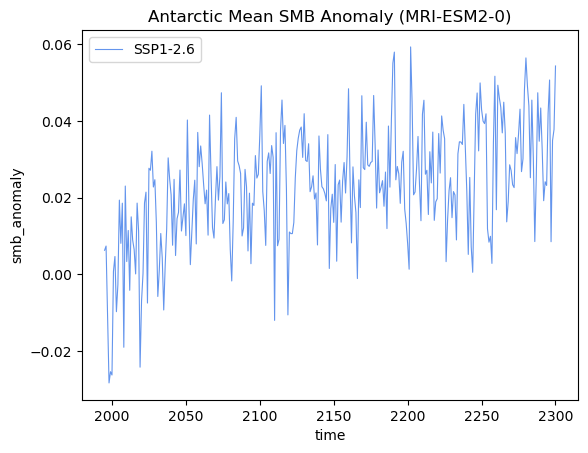

In [223]:
ts126.smb_anomaly.plot(label='SSP1-2.6', color='cornflowerblue', lw=0.8)
plt.legend()
plt.title('Antarctic Mean SMB Anomaly (MRI-ESM2-0)')

In [ ]:
normalised = ts126 / ts126.smb_anomaly.isel(time=-1)

In [ ]:
x = ts126.smb_anomaly.values
x.shape

(306,)

In [231]:
import numpy as np
T = x.size
L = 75
K = T - L + 1

X = np.empty((L, K))
for k in range(K):
    X[:, k] = x[k:k+L]
print(X.shape)

Xc = X - X.mean(axis=1, keepdims=True)
U, s, Vt = np.linalg.svd(Xc, full_matrices=False)

(75, 232)


In [232]:
print(U.shape)    # (L, r)
print(s.shape)    # (r,)
print(Vt.shape)   # (r, K)

(75, 75)
(75,)
(75, 232)


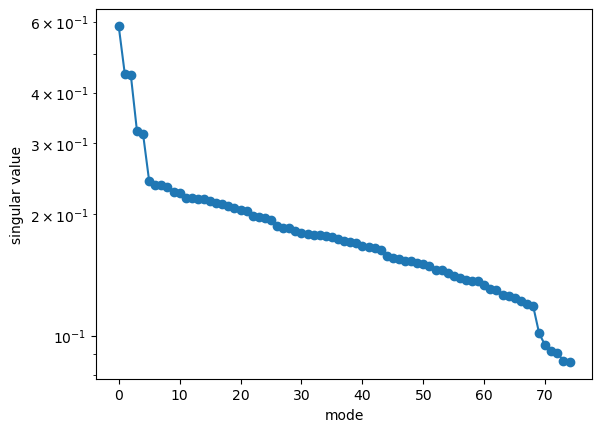

In [233]:
plt.semilogy(s, marker='o')
plt.xlabel("mode")
plt.ylabel("singular value")
plt.show()

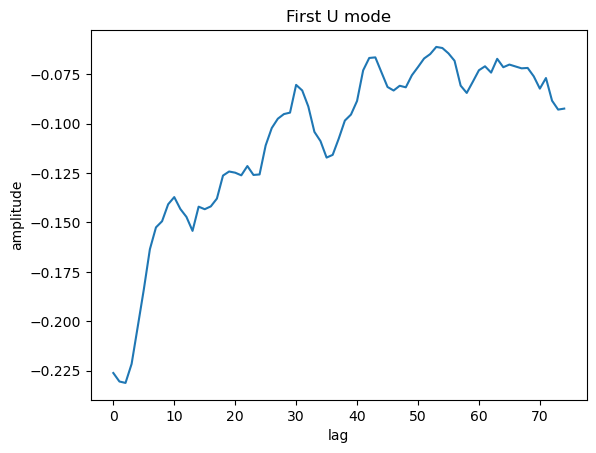

In [234]:
plt.plot(U[:, 0])
plt.xlabel("lag")
plt.ylabel("amplitude")
plt.title("First U mode")
plt.show()


In [235]:
k = 1
Xk = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

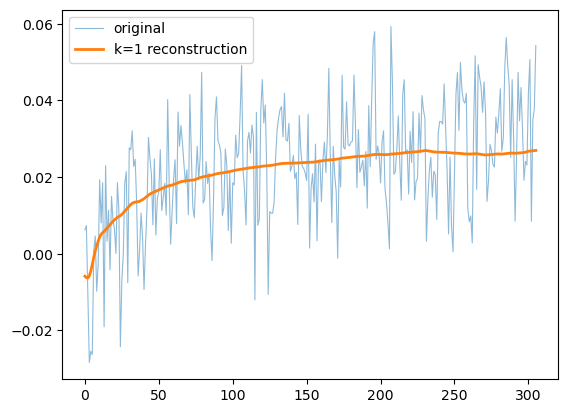

In [236]:
def diagonal_averaging(X):
    L, K = X.shape
    T = L + K - 1

    x_rec = np.zeros(T)
    counts = np.zeros(T)

    for i in range(L):
        for j in range(K):
            x_rec[i + j] += X[i, j]
            counts[i + j] += 1

    return x_rec / counts
x_trend_1 = diagonal_averaging(Xk) + x.mean()

plt.plot(x, label="original", alpha=0.5, lw=0.8)
plt.plot(x_trend_1, label="k=1 reconstruction", linewidth=2)
plt.legend()
plt.show()

# Two timeseries no lag SVD

In [250]:
path534 = Path('/Users/jonniebarnsley/data/smb_anomaly/ssp534-over/MRI-ESM2-0')
files534 = sorted(path534.glob('smb_anomaly_*.nc'))
ds534 = xr.open_mfdataset(files534, combine='nested', concat_dim='time')
ts534 = ds534.mean(dim=['x', 'y']).compute()

Text(0.5, 1.0, 'Antarctic Mean SMB Anomaly (MRI-ESM2-0)')

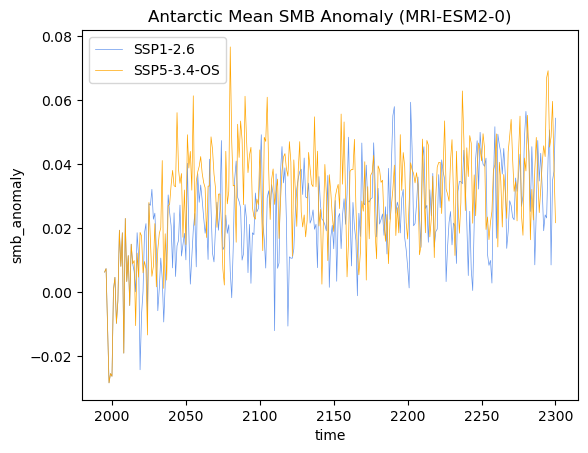

In [239]:
ts126.smb_anomaly.plot(label='SSP1-2.6', color='cornflowerblue', lw=0.5)
ts534.smb_anomaly.plot(label='SSP5-3.4-OS', color='orange', lw=0.5)
plt.legend()
plt.title('Antarctic Mean SMB Anomaly (MRI-ESM2-0)')

In [251]:
mean1 = ts126.smb_anomaly.values.mean()
mean2 = ts534.smb_anomaly.values.mean()
x1 = ts126.smb_anomaly.values - mean1
x2 = ts534.smb_anomaly.values - mean2
X = np.column_stack([x1, x2])
print(X.shape)

(306, 2)


In [252]:
# Normalise to remove effects of amplitude
Xn = X / np.linalg.norm(X, axis=0, keepdims=True)
U, s, Vt = np.linalg.svd(Xn, full_matrices=False)
print(U.shape)    # (T, 2)
print(s.shape)    # (2,)
print(Vt.shape)   # (2, 2)

print(s)

(306, 2)
(2,)
(2, 2)
[1.18225997 0.776055  ]


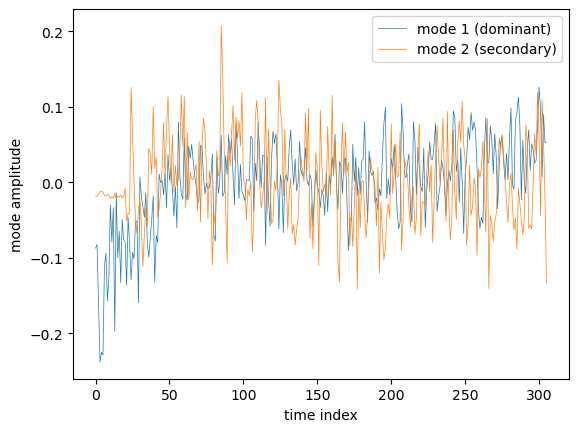

In [253]:
plt.plot(U[:, 0], label="mode 1 (dominant)", lw=0.5)
plt.plot(U[:, 1], label="mode 2 (secondary)", lw=0.5)
plt.xlabel("time index")
plt.ylabel("mode amplitude")
plt.legend()
plt.show()

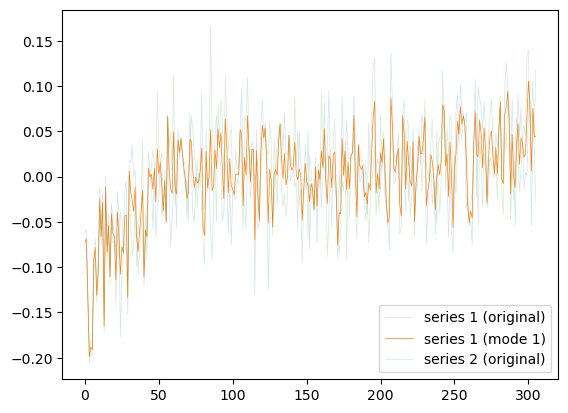

In [254]:
X_mode1 = s[0] * np.outer(U[:, 0], Vt[0, :])
plt.plot(Xn[:,0], alpha=0.2, label="series 1 (original)", lw=0.5)
plt.plot(X_mode1[:,0], label="series 1 (mode 1)", lw=0.5)
plt.plot(Xn[:,1], alpha=0.2, label="series 2 (original)", lw=0.5)
#plt.plot(X_mode1[:,1], label="series 2 (mode 1)")
plt.legend()
plt.show()

# Two timeseries with lag

In [255]:
T = x1.size
x1n = x1 / np.linalg.norm(x1)
x2n = x2 / np.linalg.norm(x2)
L = T // 4   # window length
K = T - L + 1
print(L)

76


In [256]:
def lag_embed(x, L):
    T = x.size
    K = T - L + 1
    X = np.empty((L, K))
    for j in range(K):
        X[:, j] = x[j:j+L]
    return X

X1 = lag_embed(x1n, L)
X2 = lag_embed(x2n, L)
print(X1.shape, X2.shape)  # both should be (L, K)

(76, 231) (76, 231)


In [257]:
X = np.hstack([X1, X2])  # shape (L, 2*K)
print(X.shape)

(76, 462)


In [258]:
U, s, Vt = np.linalg.svd(X, full_matrices=False)
print(U.shape, s.shape, Vt.shape)  # (L, r), (r,), (r, 2*K)

(76, 76) (76,) (76, 462)


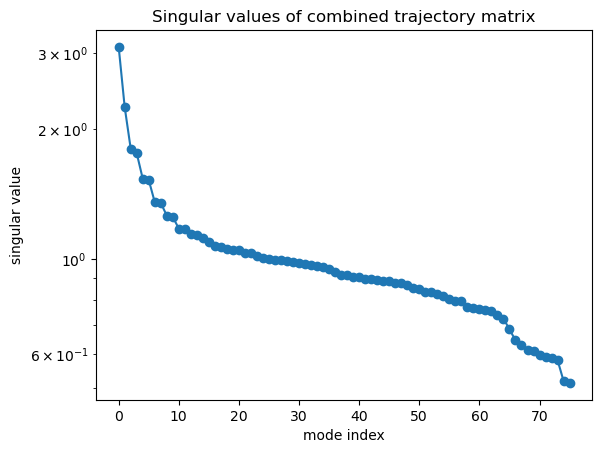

In [259]:
plt.semilogy(s, marker='o')
plt.xlabel("mode index")
plt.ylabel("singular value")
plt.title("Singular values of combined trajectory matrix")
plt.show()

In [260]:
k = 1
Xk = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

K = T - L + 1  # columns per series
X1k = Xk[:, :K]   # reconstructed series 1 trajectory
X2k = Xk[:, K:]   # reconstructed series 2 trajectory

In [261]:
def diagonal_averaging(X):
    L, K = X.shape
    T = L + K - 1
    x_rec = np.zeros(T)
    counts = np.zeros(T)
    for i in range(L):
        for j in range(K):
            x_rec[i + j] += X[i, j]
            counts[i + j] += 1
    return x_rec / counts

x1_smooth = diagonal_averaging(X1k)
x2_smooth = diagonal_averaging(X2k)

In [262]:
reconstructed1 = x1_smooth * np.linalg.norm(x1) + mean1
reconstructed2 = x2_smooth * np.linalg.norm(x2) + mean2

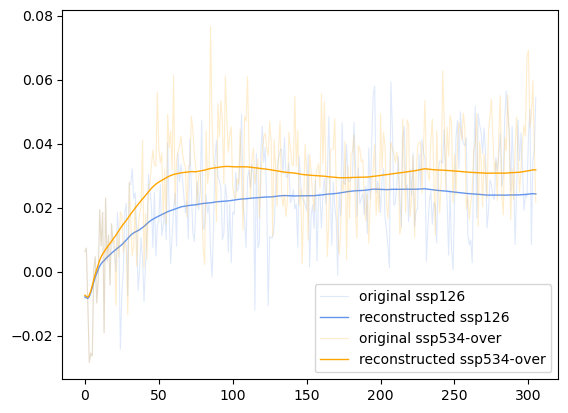

In [263]:
plt.plot(ts126.smb_anomaly, lw=0.8, alpha=0.2, label="original ssp126", color='cornflowerblue')
plt.plot(reconstructed1, linewidth=1, label="reconstructed ssp126", color='cornflowerblue')
plt.plot(ts534.smb_anomaly, lw=0.8, alpha=0.2, label="original ssp534-over", color='orange')
plt.plot(reconstructed2, linewidth=1, label="reconstructed ssp534-over", color='orange')
plt.legend()
plt.show()

## Adding a third timeseries

In [169]:
path585 = Path('/Users/jonniebarnsley/data/smb_anomaly/ssp585/MRI-ESM2-0')
files585 = sorted(path585.glob('smb_anomaly_*.nc'))
ds585 = xr.open_mfdataset(files585, combine='nested', concat_dim='time')
ts585 = ds585.mean(dim=['x', 'y']).compute()

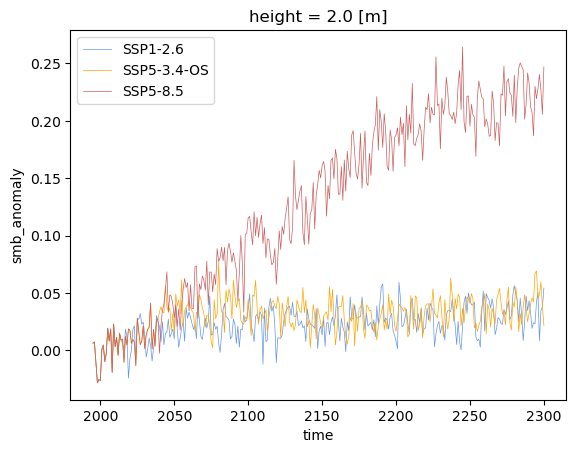

In [264]:
ts126.smb_anomaly.plot(label='SSP1-2.6', color='cornflowerblue', lw=0.5)
ts534.smb_anomaly.plot(label='SSP5-3.4-OS', color='orange', lw=0.5)
ts585.smb_anomaly.plot(label='SSP5-8.5', color='indianred', lw=0.5)
plt.legend()

In [268]:
mean3 = ts585.smb_anomaly.values.mean()
x3 = ts585.smb_anomaly.values - mean3
x3n = x3 / np.linalg.norm(x3)
X3 = lag_embed(x3n, L)

In [269]:
X = np.hstack([X1, X2, X3])   # shape (L, 3*K)
print(X.shape)

(76, 693)


In [270]:
U, s, Vt = np.linalg.svd(X, full_matrices=False)
print(U.shape, s.shape, Vt.shape)  # (L, r), (r,), (r, 3*K)

(76, 76) (76,) (76, 693)


In [288]:
k = 2
Xk = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

# split into series
X1k = Xk[:, :K]
X2k = Xk[:, K:2*K]
X3k = Xk[:, 2*K:]

In [289]:
x1_smooth = diagonal_averaging(X1k)
x2_smooth = diagonal_averaging(X2k)
x3_smooth = diagonal_averaging(X3k)

reconstructed1 = x1_smooth * np.linalg.norm(x1) + mean1
reconstructed2 = x2_smooth * np.linalg.norm(x2) + mean2
reconstructed3 = x3_smooth * np.linalg.norm(x3) + mean3

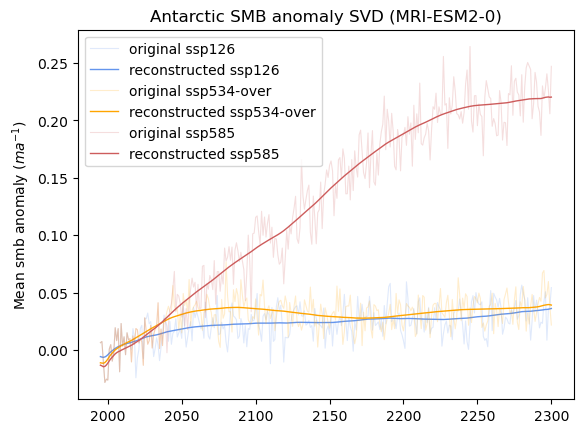

In [300]:
years = range(1995, 2301)
plt.plot(years, ts126.smb_anomaly, lw=0.8, alpha=0.2, label="original ssp126", color='cornflowerblue')
plt.plot(years, reconstructed1, linewidth=1, label="reconstructed ssp126", color='cornflowerblue')
plt.plot(years, ts534.smb_anomaly, lw=0.8, alpha=0.2, label="original ssp534-over", color='orange')
plt.plot(years, reconstructed2, linewidth=1, label="reconstructed ssp534-over", color='orange')
plt.plot(years, ts585.smb_anomaly, lw=0.8, alpha=0.2, label="original ssp585", color='indianred')
plt.plot(years, reconstructed3, linewidth=1, label="reconstructed ssp585", color='indianred')
plt.legend()
plt.title('Antarctic SMB anomaly SVD (MRI-ESM2-0)')
plt.ylabel('Mean smb anomaly ($m a^{-1}$)')
plt.show()


### Collapse trajectory contributions to a single coefficient per series

In [291]:
mode_coeffs = []
for series_idx in range(3):  # for series 1,2,3
    cols = slice(series_idx*K, (series_idx+1)*K)
    coeff = np.mean(Vt[:k, cols], axis=1)  # shape (k,)
    mode_coeffs.append(coeff)

mode_coeffs = np.array(mode_coeffs)  # shape (3, k)
print(mode_coeffs)


[[-0.00429261  0.02047566]
 [-0.00760281  0.01870542]
 [-0.00204362  0.03820093]]


In [292]:
mode_coeffs_scaled = mode_coeffs * s[:k, np.newaxis].T
mode_coeffs_scaled

array([[-0.02817434,  0.06319374],
       [-0.04990072,  0.05773027],
       [-0.01341323,  0.11789901]])

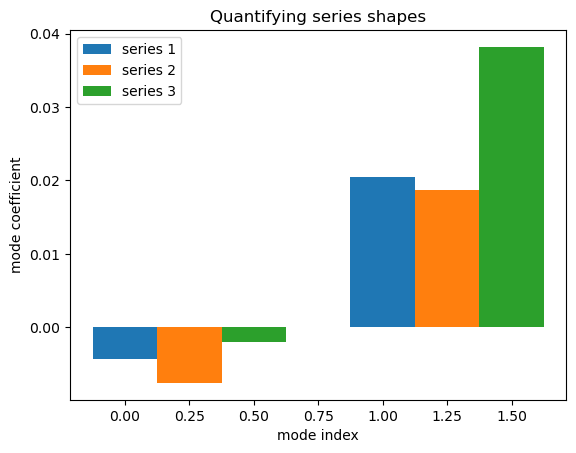

In [293]:
plt.figure()
for i in range(3):
    plt.bar(np.arange(k) + i*0.25, mode_coeffs[i], width=0.25, label=f"series {i+1}")
plt.xlabel("mode index")
plt.ylabel("mode coefficient")
plt.title("Quantifying series shapes")
plt.legend()
plt.show()
